In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical


import glob
import random
import cv2
from random import shuffle

Using TensorFlow backend.


# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [0]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)

    batch_y = to_categorical(batch_y)
    # (20, 256, 256, 1) --> (20, 256, 256, 2)

    yield (batch_x, batch_y)      
    

In [0]:
batch_size = 32 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [0]:
x, y= next(train_generator)

In [0]:
print (x.shape, y.shape)

(32, 256, 256, 3) (32, 256, 256, 2)


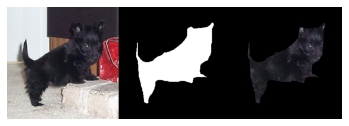

In [7]:
plt.axis('off')
img = x[0]
# img (256, 256, 3)
msk = y[0]
# mask (256, 256, 2)

msk = msk[:,:,1]
# msk[:,:,0] --> 배경이 1, 물체가 0
# msk[:,:,1] --> 배경이 0, 물체가 1
# msk (256, 256, 2) -> (256, 256)

msk = np.stack((msk,)*3, axis=-1)
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))


# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# Model

In [0]:
def mnet(shape=(256,256,3)):
  inputs = Input((shape))
  input_feature = Conv2D(16, (1,1), activation='relu')(inputs)

  # Left leg
  lef_1 = input_feature
  lef_2 = MaxPooling2D((2,2))(lef_1)
  lef_3 = MaxPooling2D((2,2))(lef_2)
  lef_4 = MaxPooling2D((2,2))(lef_3)

  # encoding
  layer_11g = Conv2D(16,(3,3),padding='same',activation='relu')(input_feature)
  layer_11b = BatchNormalization()(layer_11g)
  layer_12c = concatenate([layer_11b, input_feature])
  layer_12g = Conv2D(32,(3,3), padding='same',activation='relu')(layer_12c)
  
  layer_1m2 = MaxPooling2D((2,2))(layer_12g)

  layer_21c = concatenate([lef_2,layer_1m2])
  layer_21g = Conv2D(32, (3,3),padding='same',activation='relu')(layer_21c)
  layer_21b = BatchNormalization()(layer_21g)
  layer_22c = concatenate([layer_21b, layer_1m2])
  layer_22g = Conv2D((3,3), 48, padding='same',activation='relu')(layer_22c)

  layer_2m3 = MaxPooling2D((2,2))(layer_22g)

  layer_31c = concatenate([lef_3,layer_2m3])
  layer_31g = Conv2D((3,3),48,padding='same',activation='relu')(layer_31c)
  layer_31b = BatchNormalization()(layer_31g)
  layer_32c = concatenate([layer_31b, layer_2m3])
  layer_32g = Conv2D((3,3), 64, padding='same',activation='relu')(layer_32c)

  layer_3m4 = MaxPooling2D((2,2))(layer_32g)

  # bottom

  layer_41c = concatenate([lef_4,layer_3m4])
  layer_41g = Conv2D((3,3),64,padding='same',activation='relu')(layer_41c)
  layer_41b = BatchNormalization()(layer_41g)
  layer_42c = concatenate([layer_41b, layer_3m4])
  layer_42g = Conv2D((3,3), 128, padding='same',activation='relu')(layer_42c)
  layer_42b = BatchNormalization()(layer_42g)
  layer_43g = Conv2D((3,3),64, padding='same',activation='relu')(layer_42b)
  layer_43b = BatchNormalization()(layer_43g)

  # decoding

  layer_4u5 = UpSampling2D((2,2))(layer_43b)

  layer_51c = concatenate([layer_32g,layer_4u5])
  layer_51g = Conv2D((3,3), 64, padding='same', activation='relu')(layer_51c)
  layer_51b = BatchNormalization()(layer_51g)
  layer_52c = concatenate([layer51b,layer_4u5])
  layer_52g = Conv2D((3,3), 48, padding='same', activation='relu')(layer_52c)
  layer_52b = BatchNormalization()(layer_52g)

  layer_5u6 = UpSampling2D((2,2))(layer_52b)

  layer_61c = concatenate([layer_22g,layer_5u6])
  layer_61g = Conv2D((3,3), 48, padding='same', activation='relu')(layer_61c)
  layer_61b = BatchNormalization()(layer_61g)
  layer_62c = concatenate([layer61b,layer_5u6])
  layer_62g = Conv2D((3,3), 32, padding='same', activation='relu')(layer_62c)
  layer_62b = BatchNormalization()(layer_62g)

  layer_6u7 = UpSampling2D((2,2))(layer_62g)

  layer_71c = concatenate([layer_12g,layer_6u7])
  layer_71g = Conv2D((3,3), 32, padding='same', activation='relu')(layer_71c)
  layer_71b = BatchNormalization()(layer_71g)
  layer_72c = concatenate([layer71b,layer_6u7])
  layer_72g = Conv2D((3,3), 16, padding='same', activation='relu')(layer_72c)
  layer_72b = BatchNormalization()(layer_72g)

  # right leg
  rig_1 = UpSampling2D((8,8))(layer_43b)
  rig_2 = UpSampling2D((4,4))(layer_52b)
  rig_3 = UpSampling2D((2,2))(layer_62b)
  rig_4 = concatenate([rig_1,rig_2,rig_3])

  # fin 
  con = concatenate([layer_72b,rig_4])
  outputs = Conv2D(2,1, activation='relu',padding='same')(con)

  model = Model(inputs=[inputs], outputs=[outputs])

  model.compile(optimizer = 'rmsprop', loss = bice_dice_loss, metrics=[dice_coef])
  
  return model


  




In [16]:
model = mnet()

TypeError: ignored

In [0]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        # input --> (1, 256,256, 3)
        # shape of pred --> (1, 256, 256, 2)
        
        msk = np.argmax(pred, axis=-1)
        # (1, 256, 256, 2) -> (1, 256, 256)
        msk  = msk.squeeze()
        # (1, 256, 256) --> (256, 256)
        msk = np.stack((msk,)*3, axis=-1)
        # (256, 256) --> (256, 256, 3)
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [0]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print (train_steps, test_steps)

219 11


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
i= 1 loss= 0.4078899095319722 val_loss= 1.6348457553169944 mean_dsc= 0.68613577 val_mean_dsc= 0.6813131


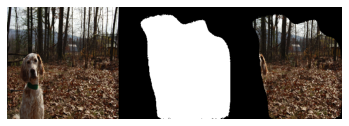

i= 2 loss= 0.2635081072920534 val_loss= 0.3655779253352772 mean_dsc= 0.8113709 val_mean_dsc= 0.82287675


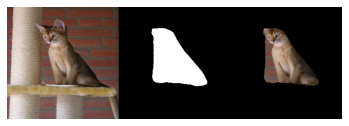

i= 3 loss= 0.2141318902305272 val_loss= 0.24934872849421066 mean_dsc= 0.85109305 val_mean_dsc= 0.8319294


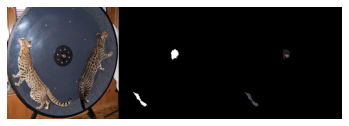

i= 4 loss= 0.18855234728828413 val_loss= 0.19715388932011343 mean_dsc= 0.86884034 val_mean_dsc= 0.86518663


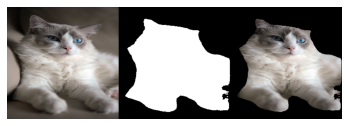

i= 5 loss= 0.1720408905450612 val_loss= 0.1887548416852951 mean_dsc= 0.883806 val_mean_dsc= 0.865732


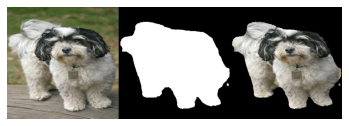

i= 6 loss= 0.15778604643121702 val_loss= 0.19972283054481854 mean_dsc= 0.8908029 val_mean_dsc= 0.87049013


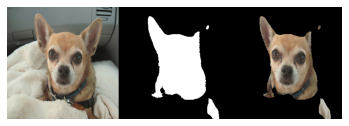

i= 7 loss= 0.14755896727244058 val_loss= 0.19462898644534024 mean_dsc= 0.8994863 val_mean_dsc= 0.87199664


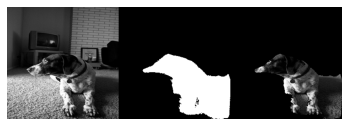

i= 8 loss= 0.1387287124174915 val_loss= 0.22494712201031772 mean_dsc= 0.9051783 val_mean_dsc= 0.8547167


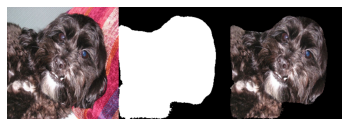

i= 9 loss= 0.133579025257668 val_loss= 0.21141570671038193 mean_dsc= 0.9101432 val_mean_dsc= 0.87018865


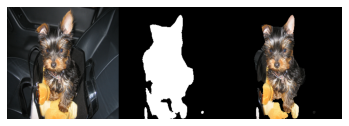

i= 10 loss= 0.12433690707024918 val_loss= 0.16225029934536328 mean_dsc= 0.9153034 val_mean_dsc= 0.89491946


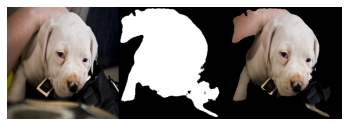

i= 11 loss= 0.11762230816088855 val_loss= 0.22265174984931946 mean_dsc= 0.919777 val_mean_dsc= 0.8728954


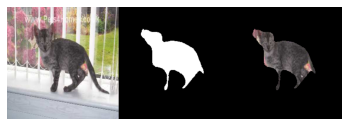

i= 12 loss= 0.11103401656292344 val_loss= 0.20304985615340146 mean_dsc= 0.92466724 val_mean_dsc= 0.89020705


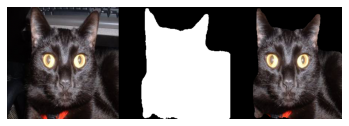

i= 13 loss= 0.10830571985544135 val_loss= 0.22142175110903653 mean_dsc= 0.926813 val_mean_dsc= 0.87174165


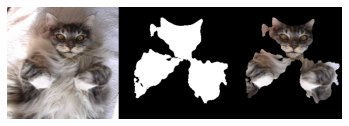

i= 14 loss= 0.1051997673021604 val_loss= 0.1812665814703161 mean_dsc= 0.92888784 val_mean_dsc= 0.8901327


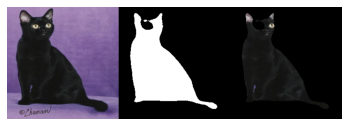

i= 15 loss= 0.0998391823749564 val_loss= 0.18179525909098712 mean_dsc= 0.93202895 val_mean_dsc= 0.8917102


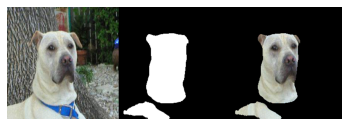

i= 16 loss= 0.09593145518678509 val_loss= 0.19173012741587378 mean_dsc= 0.9342372 val_mean_dsc= 0.89731944


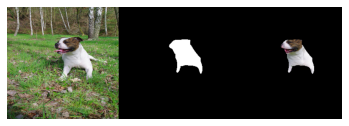

i= 17 loss= 0.09058397314319871 val_loss= 0.1730670170350508 mean_dsc= 0.9382837 val_mean_dsc= 0.8968054


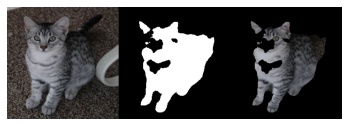

i= 18 loss= 0.08921666752938266 val_loss= 0.21450649472800168 mean_dsc= 0.93977207 val_mean_dsc= 0.8766409


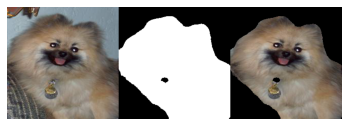

i= 19 loss= 0.08427421709514099 val_loss= 0.19793025878342715 mean_dsc= 0.94260633 val_mean_dsc= 0.89638686


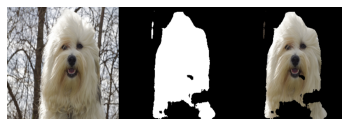

i= 20 loss= 0.08418904663357016 val_loss= 0.162251201542941 mean_dsc= 0.9423884 val_mean_dsc= 0.90475374


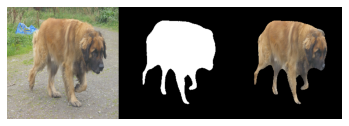

i= 21 loss= 0.08126816679149458 val_loss= 0.1911967613480308 mean_dsc= 0.9449363 val_mean_dsc= 0.9016815


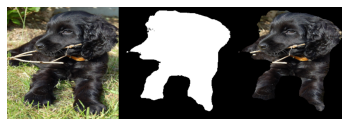

i= 22 loss= 0.07599493589031098 val_loss= 0.23026695847511292 mean_dsc= 0.94649166 val_mean_dsc= 0.8876763


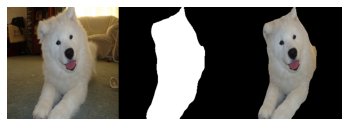

i= 23 loss= 0.07471207369408106 val_loss= 0.18845027820630508 mean_dsc= 0.9481866 val_mean_dsc= 0.8984354


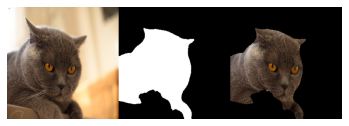

i= 24 loss= 0.07160608286726965 val_loss= 0.2748557396910407 mean_dsc= 0.9497044 val_mean_dsc= 0.86232847


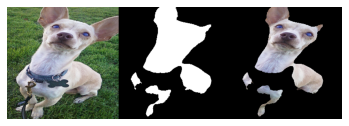

i= 25 loss= 0.07000428661023646 val_loss= 0.20740466903556476 mean_dsc= 0.9505469 val_mean_dsc= 0.87760806


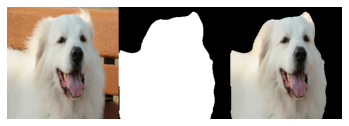

i= 26 loss= 0.06886688380004609 val_loss= 0.16644920137795535 mean_dsc= 0.95195556 val_mean_dsc= 0.9041922


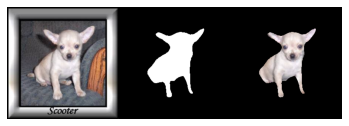

i= 27 loss= 0.06684136681564867 val_loss= 0.20980035852302203 mean_dsc= 0.95348716 val_mean_dsc= 0.8970902


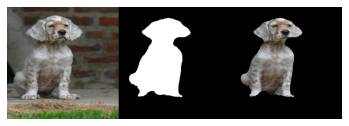

i= 28 loss= 0.065239187755269 val_loss= 0.20762582123279572 mean_dsc= 0.95412964 val_mean_dsc= 0.9043564


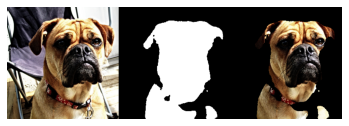

i= 29 loss= 0.06423346893904416 val_loss= 0.170766491104256 mean_dsc= 0.95498705 val_mean_dsc= 0.907622


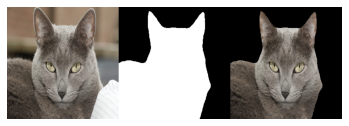

i= 30 loss= 0.06221989348326644 val_loss= 0.22804671119559894 mean_dsc= 0.9559329 val_mean_dsc= 0.9044016


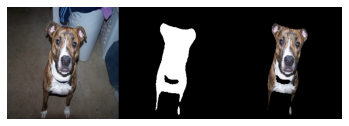

In [0]:
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [0]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-03-07 15:54:56--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.226.15.41, 13.226.15.118, 13.226.15.105, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.226.15.41|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.005s  

2020-03-07 15:54:56 (12.0 MB/s) - ‘test.jpg’ saved [63219/63219]



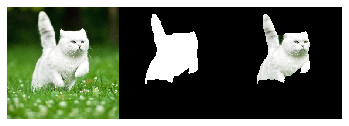

In [0]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
# msk  = pred.squeeze()
# msk = np.stack((msk,)*3, axis=-1)
# msk[msk >= 0.5] = 1 
# msk[msk < 0.5] = 0 

msk = np.argmax(pred, axis=-1)
# (1, 256, 256)
msk  = msk.squeeze()
# (256, 256)
msk = np.stack((msk,)*3, axis=-1)
# (256, 256, 3)

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

